In [2]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from keras import regularizers

Using TensorFlow backend.


In [3]:
#loading data
DDataFile = './data/processed_features_U50K_100K_200K/D_VLOS_scaled_mean_mean_alpha6_fft_abs_Frobenius_sphericalWave_B32_U200000.mat'
DData = sio.loadmat(DDataFile)

LocationDataFile = './data/randLocationU200000VIP.mat'
locationData = sio.loadmat(LocationDataFile)


In [4]:
#preprocessing the data
D_data = np.transpose(DData['D'])
location_data = np.transpose(locationData['location'])
location_data = location_data[:,:2]

#print(D_data.shape)
total, l = D_data.shape
total, d = location_data.shape

train_length = int(np.floor(total * 0.8))

impulses_train = D_data[:train_length, :]
location_train = location_data[:train_length,:]
print(total,train_length, impulses_train.shape, location_train.shape)

impulses_test = D_data[train_length:, :]
location_test = location_data[train_length:,:]

200000 160000 (160000, 1024) (160000, 2)


The **best** result for now is use **Three 1024** hidden layers and activation is relu, the actual error distance is 25.8, lr = 0.0001
-  ~~the first layer is 256~~
- ~~decrease lr = 0.00001~~
- ~~*bitch size changes to  32, the avgrage actual error distance is 26.86*~~
- ~~try to sort the data according to the location x and use the half of data to calculate~~
- change the size of validation to 0.1 --> **The best result** 25.45, whose number of the layers is three

- ~~add one more layer 1024, which means there are four 1024 layers --> the result is 28.6~~
- ~~add some dropout(0.2) -> 26.57~~
- ~~add regularizaers {kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l1(0.01)} in threethree Dense layers-> result26.42~~
- ~~add normalization for every layers -> result is 26.49, mim = 0.04 loss_min=720, max_dis=172~~
- no normalization , delete kernel_regularizer and keep the activity_regularizer
- the first layer is 512, the min of error is 25, could considering
- ~~three layers are replaced by 128 -> not good enough, the mean is 36 and the distribution is not good the mod is located 20~~
- ~~only change the first layer to 128  (0.18-166) mean = 25.67 but the mode is located 10-20~~
- change the first layer to 128 and add one more 1024 layers ->(0.24-151) mean = 25.4 

try 50k data ->(0.05,290) mean=23.48 (128 layer and 1024*3 layers)
try 200k data -> (0.036-1930) mean=22.8, loss=474


In [5]:
#Build the model
model = keras.Sequential()
#keras.layers.normalization.BatchNormalization()
model.add(Dense(128, activation = 'relu', 
                #kernel_regularizer=regularizers.l2(0.01),
                #activity_regularizer=regularizers.l1(0.01)
               ))  #the hidden layer
#keras.layers.normalization.BatchNormalization()
model.add(Dense(1024, activation = 'relu', 
                #kernel_regularizer=regularizers.l2(0.01),
               # activity_regularizer=regularizers.l1(0.01)
               ))   #the hidden layer number 
# model.add(Dropout(0.2)) # best 0.2
#keras.layers.normalization.BatchNormalization()
model.add(Dense(1024, activation = 'relu', 
                #kernel_regularizer=regularizers.l2(0.01),
               # activity_regularizer=regularizers.l1(0.01)
               )) 
model.add(Dense(1024, activation = 'relu', 
                #kernel_regularizer=regularizers.l2(0.01),
               # activity_regularizer=regularizers.l1(0.01)
               )) 
#model.add(Dropout(0.2)) # best 0.2
#keras.layers.normalization.BatchNormalization()
model.add(Dense(d, activation = 'linear'))  # None is different from 'linear'      ### the output layer

In [6]:
#Compilation
loss_func = 'mean_squared_error'   #   categorical_crossentropy(bad)   mean_squared_error
opt_func = keras.optimizers.Adam(lr=0.0001) #'Adam'  lr=0.001  #  RMSprop(overfiiting) sgd(overfitting)  Adadelta(overfitting)   Adam

model.compile(loss = loss_func, 
              optimizer = opt_func
             )

In [7]:
#Train the model, iterating
early_stop = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.1)
history = model.fit(impulses_train, location_train,
                    batch_size = 50, # 10,20
                    epochs = 200,
                    verbose = 2,
                    validation_split = 0.1 #0.2
                    #validation_data=(impulses_test, location_test)
                   )


Train on 144000 samples, validate on 16000 samples
Epoch 1/200
 - 206s - loss: 9846.3397 - val_loss: 1818.3120
Epoch 2/200
 - 199s - loss: 1670.6025 - val_loss: 1504.0199
Epoch 3/200
 - 197s - loss: 1372.5094 - val_loss: 1237.8335
Epoch 4/200
 - 196s - loss: 1139.4920 - val_loss: 1044.7741
Epoch 5/200
 - 196s - loss: 976.3761 - val_loss: 893.2178
Epoch 6/200
 - 196s - loss: 825.3956 - val_loss: 834.6135
Epoch 7/200
 - 196s - loss: 696.9143 - val_loss: 623.9375
Epoch 8/200
 - 197s - loss: 610.1383 - val_loss: 578.7747
Epoch 9/200
 - 197s - loss: 558.7858 - val_loss: 571.6172
Epoch 10/200
 - 197s - loss: 520.8814 - val_loss: 687.4108
Epoch 11/200
 - 198s - loss: 500.3732 - val_loss: 514.6231
Epoch 12/200
 - 199s - loss: 483.6257 - val_loss: 467.2491
Epoch 13/200
 - 196s - loss: 471.1943 - val_loss: 525.1306
Epoch 14/200
 - 199s - loss: 456.3871 - val_loss: 503.3604
Epoch 15/200
 - 201s - loss: 449.0491 - val_loss: 485.8597
Epoch 16/200
 - 198s - loss: 439.2415 - val_loss: 616.7864
Epoch 

Epoch 139/200
 - 199s - loss: 222.5751 - val_loss: 423.3789
Epoch 140/200
 - 197s - loss: 219.3474 - val_loss: 425.0044
Epoch 141/200
 - 196s - loss: 221.7322 - val_loss: 404.6001
Epoch 142/200
 - 198s - loss: 217.8562 - val_loss: 430.0483
Epoch 143/200
 - 198s - loss: 218.8605 - val_loss: 441.2024
Epoch 144/200
 - 198s - loss: 214.8047 - val_loss: 429.2214
Epoch 145/200
 - 197s - loss: 214.4961 - val_loss: 427.4885
Epoch 146/200
 - 198s - loss: 213.1743 - val_loss: 422.6508
Epoch 147/200
 - 201s - loss: 212.7172 - val_loss: 434.3575
Epoch 148/200
 - 200s - loss: 212.0813 - val_loss: 433.3362
Epoch 149/200
 - 200s - loss: 210.3077 - val_loss: 424.0317
Epoch 150/200
 - 203s - loss: 208.7713 - val_loss: 442.2019
Epoch 151/200
 - 199s - loss: 208.2898 - val_loss: 433.6493
Epoch 152/200
 - 200s - loss: 208.2035 - val_loss: 451.7519
Epoch 153/200
 - 202s - loss: 203.6375 - val_loss: 444.9022
Epoch 154/200
 - 201s - loss: 204.9892 - val_loss: 439.7486
Epoch 155/200
 - 201s - loss: 201.5148 -

In [8]:
#make prediction
loc_prediction = model.predict(impulses_test)
print(loc_prediction.shape)
print(location_test.shape)

(40000, 2)
(40000, 2)


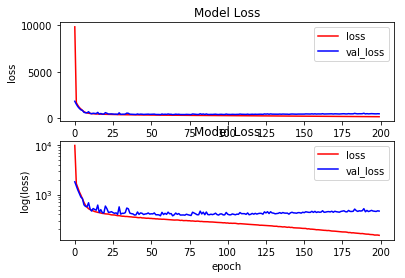

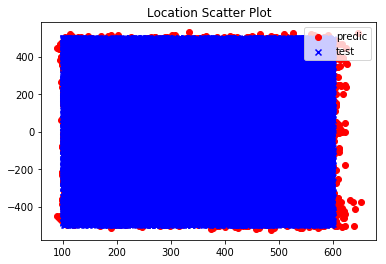

In [9]:
#plot the loss data
import math
plt.subplot(211)
plt.plot(history.history['loss'],'r',label = 'loss')
plt.plot(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(212)
plt.semilogy(history.history['loss'],'r',label = 'loss')
plt.semilogy(history.history['val_loss'],'b', label = 'val_loss')
plt.title('Model Loss')
plt.ylabel('log(loss)')
plt.xlabel('epoch')
plt.legend()

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_title('Location Scatter Plot')
ax1.scatter(loc_prediction[:,0],loc_prediction[:,1],c = 'r',marker = 'o', label = 'predic')
ax1.scatter(location_test[:,0],location_test[:,1],c = 'b',marker = 'x', label = 'test')
plt.legend()
plt.show()

In [10]:
#The training result
loss = model.evaluate(impulses_test, location_test, verbose=1)
print ('Test loss & mean_absolute_error: ', loss)

40000/40000 [==============================] - 9s 230us/step
Test loss & mean_absolute_error:  474.44706131591795


error distance is  22.8127284544239
max error distance is  193.11029099087233
min error distance is  0.03616177585688862


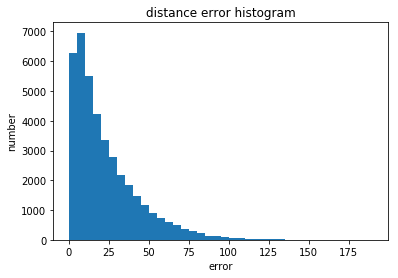

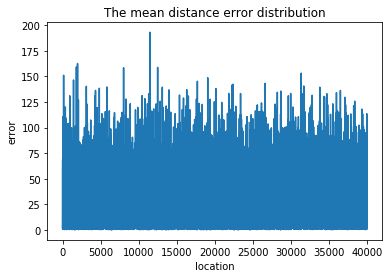

(40000, 1)

In [14]:
#calculate the mean of error distance
err = loc_prediction - location_test
x = err[:,:1]
y = err[:,1:]

err_dis = np.sqrt(np.square(x)+np.square(y))
err_min = np.min(err_dis)
err_max = np.max(err_dis)
err_avg = np.mean(err_dis)
print("error distance is ", err_avg)
print("max error distance is ", err_max)
print("min error distance is ", err_min)
#set the value of x, y, z
x,y,z = location_test[:,:1],location_test[:,1:2],err_dis

#plot the 2D image of error
plt.figure(1)
#plt.subplot(2,1,2)
plt.hist(err_dis, bins =  range(0,195,5)) 
plt.xlabel("error")
plt.ylabel("number")
plt.title("distance error histogram") 

plt.figure(2)
#plt.subplot(2,1,1)
plt.plot(err_dis)
plt.title("The mean distance error distribution")
plt.xlabel("location")
plt.ylabel("error")
plt.show()
x.shape

Text(0.5, 0.92, 'The mean distance error of 3D Iamge')

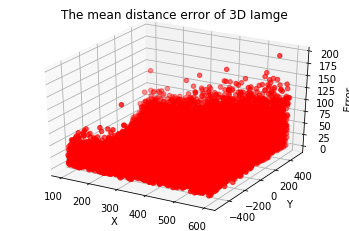

In [12]:
#plot 3D image
ax = plt.subplot(111,projection='3d')
ax.scatter(x,y,z,c='r')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Error")
plt.title("The mean distance error of 3D Iamge")

Text(0.5, 1.0, "The mean distance error of 'heat map'")

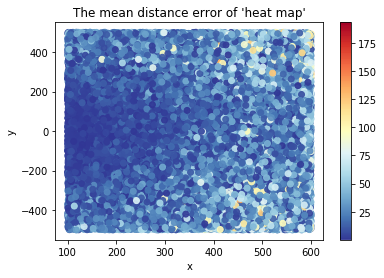

In [13]:
#draw the "heatmap" of error
fig = plt.figure()
ax3 = fig.add_subplot(111)
cm = plt.cm.get_cmap('RdYlBu_r') #Accent  RdYlBu_r RdYlBu  Blues_r  Greens  YlOrBr_r

sc = ax3.scatter(x,y,c = z, marker = 'o', label = 'test',alpha=0.9, cmap=cm)
plt.colorbar(sc)
ax3.set_xlabel("x")
ax3.set_ylabel("y")
plt.title("The mean distance error of 'heat map'")